In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import pandas as pd
import numpy as np

def findFiles(path): return glob.glob(path)

print(findFiles('data/labels/*.txt'))

all_letters = "arndbceqzghilkmfpstwyv"
n_letters = len(all_letters)


# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return lines

for filename in findFiles('data/labels/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/labels/positive.txt', 'data/labels/negative.txt']


In [3]:
# make sure negative index is 0
all_categories.sort()
all_categories

['negative', 'positive']

In [4]:
n_letters

22

In [5]:
print(category_lines['positive'][:5])

['AAIANYHYDADENSK', 'AGTWSALNSIQQFIS', 'AKGMMHMIKKGANGS', 'ALREKVLGLPAIKAW', 'ATDYENYAIVEGCPA']


In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    line = line.lower()
    tensor = torch.tensor([letterToIndex(letter) for letter in line], dtype=torch.long).to(device) 
    tensor = tensor.view(-1, 1)
    return tensor

print(lineToTensor('AAIANYHYDADENSK'))
print(lineToTensor('AAIANYHYDADENSK').size())

tensor([[ 0],
        [ 0],
        [11],
        [ 0],
        [ 2],
        [20],
        [10],
        [20],
        [ 3],
        [ 0],
        [ 3],
        [ 6],
        [ 2],
        [17],
        [13]])
torch.Size([15, 1])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.e = nn.Embedding(input_size, input_size//2)
        self.lstm = nn.LSTM(input_size//2, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedding = self.e(input)
        embedding = embedding.view(1, 1, -1)
        lstm_out, hidden = self.lstm(
            embedding, hidden)
        output = self.softmax(self.i2o(lstm_out.view(1, -1)))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size).to(device) ,
                torch.zeros(1, 1, self.hidden_size).to(device))

n_hidden = 128
model = MyLSTM(n_letters, n_hidden, n_categories).to(device)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [8]:
input = lineToTensor('AAIANYHYDADENSK')
hidden = model.initHidden()

output, next_hidden = model(input[0], hidden)
print(input[0])
print(output)
print(output.shape)

tensor([0])
tensor([[-0.6705, -0.7163]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 2])


Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('negative', 0)


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = negative / line = PTLHGPTPLLYRLGA
category = negative / line = SKAIIVGPKAYVNPI
category = positive / line = RKLRTLILAPTRVVA
category = negative / line = DPETIFHPGSLQCVD
category = negative / line = RVVDGAVGAQWLAEF
category = negative / line = AALPLLFFALAGQRI
category = negative / line = YPWPLYGNEGLGWAG
category = positive / line = LRGFRKEIGRMLNIL
category = negative / line = MFESKSMKLRTQIPA
category = negative / line = SIIILEILGIDRKPT


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [11]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [12]:
def train(category_tensor, line_tensor):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [13]:
import time
import math

n_iters = 5000
print_every = 500
plot_every = 500



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 10% (0m 6s) 0.6713 TAASAAQRRGRVGRN / negative ✓
1000 20% (0m 13s) 0.6567 MLNIMNRRKRSVTML / positive ✓
1500 30% (0m 21s) 0.6454 IREAIKRKLRTLILA / negative ✓
2000 40% (0m 29s) 0.7057 NTQFQKRSYQMYRSL / positive ✗ (negative)
2500 50% (0m 36s) 0.5742 KFEGNKFTIDYNDKG / positive ✓
3000 60% (0m 44s) 0.5242 NIPATWGAMEKLYDA / negative ✓
3500 70% (0m 51s) 0.5274 MIVDTISDFRAAIAN / positive ✓
4000 80% (0m 58s) 0.7819 AEYVQIIHTSNYLGT / negative ✗ (positive)
4500 90% (1m 6s) 1.0148 ASNWYFNHLKDKILG / positive ✗ (negative)
5000 100% (1m 13s) 0.9930 VLQCLMKILTIDLII / positive ✗ (negative)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




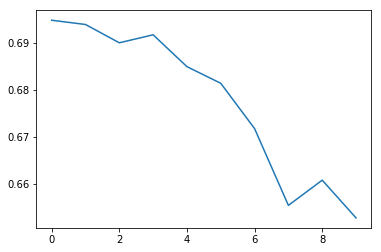

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [15]:
all_losses[-5:]

[0.6813723776340485,
 0.6717355996370316,
 0.6553935186266899,
 0.6607642878293991,
 0.6527296549677849]

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




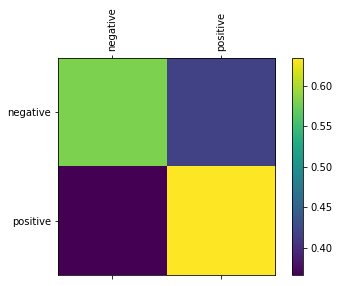

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    with torch.no_grad():
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
torch.save(model, "models/lstm_2000.pth")

/Users/ytian/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MyLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
import pandas as pd
import numpy as np

valid = pd.read_csv("data/valid.csv")
valid["Immunogenicity"] = valid["Immunogenicity"].map(lambda n: 0 if n == -1 else n)
valid.head()

,PubMed ID,Peptide,Immunogenicity
0,1706620,QGHNMPNDPNRNVDENANAN,1
1,1706620,VTCGNGIQVRIKPGSANKPK,1
2,11241296,AAFVGAAATLVSLLTFMIAATYNFAVLKLMGR,1
3,11241296,ENPVVHFFKNIVTPRTP,1
4,11241296,GTASFFFLYGALLLAYGFYTTGAVRQIFGDYK,1


In [19]:
len(valid["PubMed ID"].unique())

57

In [20]:
# group by PubMedi ID
grouped = valid.groupby("PubMed ID")

In [21]:
auc_scores = []

In [22]:
def predict(peptide):
    with torch.no_grad():
        output = evaluate(lineToTensor(peptide))
        log_prob = output[0][1].item()
        prob = np.exp(log_prob)
        
        top_v, top_i = output.topk(1)
        category_i = top_i[0].item()
        return (prob, category_i)

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

for _, group in grouped:
    valid_peptides = group["Peptide"].tolist()
    valid_targets = group["Immunogenicity"].tolist()
    
    probs = []
    predictions = []

    for peptide in valid_peptides:
        prob, pred = predict(peptide)
        probs.append(prob)
        predictions.append(pred)
        
    auc_score = roc_auc_score(valid_targets, probs)
    auc_scores.append(auc_score)

In [24]:
print(len(auc_scores))

57


In [25]:
auc_scores = np.asarray(auc_scores)
auc_scores.mean()

0.61149316251471908

In [26]:
auc_scores

array([ 0.54166667,  0.1875    ,  0.66666667,  0.48571429,  0.48571429,
        0.48979592,  0.5       ,  0.55555556,  0.68571429,  0.59013605,
        0.41176471,  0.65      ,  0.71428571,  0.86111111,  0.84      ,
        0.715     ,  0.47222222,  0.69047619,  0.49662162,  0.68686869,
        1.        ,  0.42857143,  0.55714286,  0.74444444,  0.45604396,
        0.61875   ,  0.65614035,  0.69387755,  0.63736264,  1.        ,
        0.72786885,  0.22916667,  0.7       ,  0.65833333,  0.56387808,
        0.5016835 ,  0.59375   ,  0.52586207,  0.75231481,  0.51820728,
        0.64935065,  0.77708333,  0.52777778,  0.40909091,  0.71759259,
        0.58467742,  0.66666667,  0.66666667,  0.875     ,  0.79545455,
        0.37948718,  0.64130435,  0.61574074,  0.68387097,  0.32051282,
        0.44509804,  0.80952381])